In [9]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
import pandas as pd
import os
import torch
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
def filter_inadequada(example):
    return example["INADEQUADA"] == 0

ds = load_dataset("higopires/RePro-categories-multilabel")
print(len(ds["train"]))
#remove INADEQUADA examples
ds = ds.filter(filter_inadequada)
#remove only keep the firs 1000 examples
#ds["train"] = ds["train"].filter(lambda example, idx: idx < 1000, with_indices=True)
#ds["test"] = ds["test"].filter(lambda example, idx: idx < 1000, with_indices=True)
#ds["validation"] = ds["validation"].filter(lambda example, idx: idx < 1000, with_indices=True)
print(len(ds["train"]))

8002
7674


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForSequenceClassification.from_pretrained("Large_Bert_model",num_labels=5,problem_type="multi_label_classification")
tokenizer = AutoTokenizer.from_pretrained("Large_Bert_model")


In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities and then to binary predictions
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
    print(f"DEBUG: Original logits shape: {logits.shape}")
    print(f"DEBUG: Original labels shape: {labels.shape}")
    # Calculate sample-wise F1 score
    f1 = f1_score(labels, predictions, average='micro', zero_division=0)
    precision = precision_score(labels, predictions, average='micro', zero_division=0)

    recall = recall_score(labels, predictions, average='micro', zero_division=0)
    return {'f1_micro': float(f1), 'precision': float(precision), 'recall': float(recall)}
def preprocess_function(sample):
    # Tokenize text
    tokenized = tokenizer(sample["review_text"], truncation=True, padding=True, max_length=512, return_tensors="pt")
    
    # Convert binary label columns to a list (e.g., [1, 0, 1, 0, 0, 0])
    labels = []
    for i in range(len(sample["review_text"])):
        label_row = [
            float(sample["ENTREGA"][i]),
            float(sample["OUTROS"][i]),
            float(sample["PRODUTO"][i]),
            float(sample["CONDICOESDERECEBIMENTO"][i]),
            float(sample["ANUNCIO"][i])
        ]
        labels.append(label_row)
    
    tokenized["labels"] = torch.tensor(labels, dtype=torch.float)
    return tokenized
#check if output layer has 5 outputs
#print(model.classifier.out_features)
#model.classifier.out_features = 5  # Explicitly ensure final layer has 5 outputs

In [12]:
model.to(device)
tokenized_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/966 [00:00<?, ? examples/s]

In [13]:
training_args = TrainingArguments(
    output_dir="./resultsTransformer",
    learning_rate=1e-5,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


C:\Users\tomas\AppData\Local\Temp\ipykernel_14412\2190794626.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
y_pred = trainer.predict(tokenized_dataset["test"])
y_pred.metrics

DEBUG: Original logits shape: (966, 5)
DEBUG: Original labels shape: (966, 5)


{'test_loss': 0.16487807035446167,
 'test_model_preparation_time': 0.004,
 'test_f1_micro': 0.9478487614080834,
 'test_precision': 0.9429312581063554,
 'test_recall': 0.9528178243774574,
 'test_runtime': 45.9553,
 'test_samples_per_second': 21.02,
 'test_steps_per_second': 4.221}

In [15]:
predictions = y_pred.predictions
print(y_pred.metrics)
# Apply sigmoid and threshold for multi-label classification
pred_probs = torch.sigmoid(torch.tensor(predictions))
y_pred_labels = (pred_probs > 0.5).int().numpy()  # Threshold at 0.5

# Get true labels
y_true = np.array(tokenized_dataset["test"]["labels"]).astype(int)

{'test_loss': 0.16487807035446167, 'test_model_preparation_time': 0.004, 'test_f1_micro': 0.9478487614080834, 'test_precision': 0.9429312581063554, 'test_recall': 0.9528178243774574, 'test_runtime': 45.9553, 'test_samples_per_second': 21.02, 'test_steps_per_second': 4.221}


In [16]:
import pandas as pd

# Get indices of misclassified examples
misclassified_mask = np.any(y_pred_labels != y_true, axis=1)
misclassified_indices = np.where(misclassified_mask)[0]

# Create DataFrame with all test examples and predictions
results_df = pd.DataFrame({
    "text": tokenized_dataset["test"]["review_text"],
    "true_labels": [list(x) for x in y_true],
    "pred_labels": [list(x) for x in y_pred_labels],
    "correct": ~misclassified_mask
})

# Filter to only misclassified examples
misclassified_df = results_df[results_df["correct"] == False]

In [19]:
# Print some misclassified examples
error_Results = 50
for idx, row in misclassified_df.head(error_Results).iterrows():
    print(f"Text: {row['text']}")
    print(f"True labels: {row['true_labels']}")
    print(f"Predicted labels: {row['pred_labels']}")
    print("-" * 50)

Text: ESSE PRODUTO PODE ATÉ SER BOM, PORÉM, A AMERICANAS JÁ NÃO ME INSPIRA MUITA CONFIANÇA. NÃO PELA AMERICANAS EM SI, POIS SEMPRE FORA UMA EMPRESA SÉRIA. A ÚLTIMA COMPRA QUE EFETUEI, A AMERICANAS COLOCOU AOS CUIDADOS DA "DIRECT". ME CAUSARAM MUITOS PROBLEMAS PARA ENTREGAR O PRODUTO, QUE NA OCASIÃO ERA UM CELULAR. PRECISEI ACIONAR O RECLAME AQUI PARA ME AJUDAR.... NÃO FOI FÁCIL!!!!! GOSTARIA DE COMPRAR ESSE PRODUTO : Kit Com 10 Cuecas Boxer de Cotton 4.0 - Polo Match....., PORÉM NÃO SEI SE TEREI PROBLEMAS NOVAMENTE. COMPLICADO!!
True labels: [1, 1, 0, 0, 0]
Predicted labels: [1, 1, 1, 0, 0]
--------------------------------------------------
Text: Quero saber quando chegará mais pois gostaria de comprar
True labels: [0, 1, 0, 0, 0]
Predicted labels: [1, 1, 0, 0, 0]
--------------------------------------------------
Text: Excelente produto podem confiar  Entrega rápida sem nenhum problema
True labels: [1, 0, 1, 0, 0]
Predicted labels: [1, 0, 1, 1, 0]
-------------------------------------

# Draw Confusion Matrix

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
columns = ["ENTREGA", "OUTROS", "PRODUTO", "CONDICOESDERECEBIMENTO", "ANUNCIO"]
num_labels = len(columns)
def plot_label_confusion_matrix(y_true, y_pred, label_idx, label_name):
    cm = confusion_matrix(y_true[:, label_idx], y_pred[:, label_idx])
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {label_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


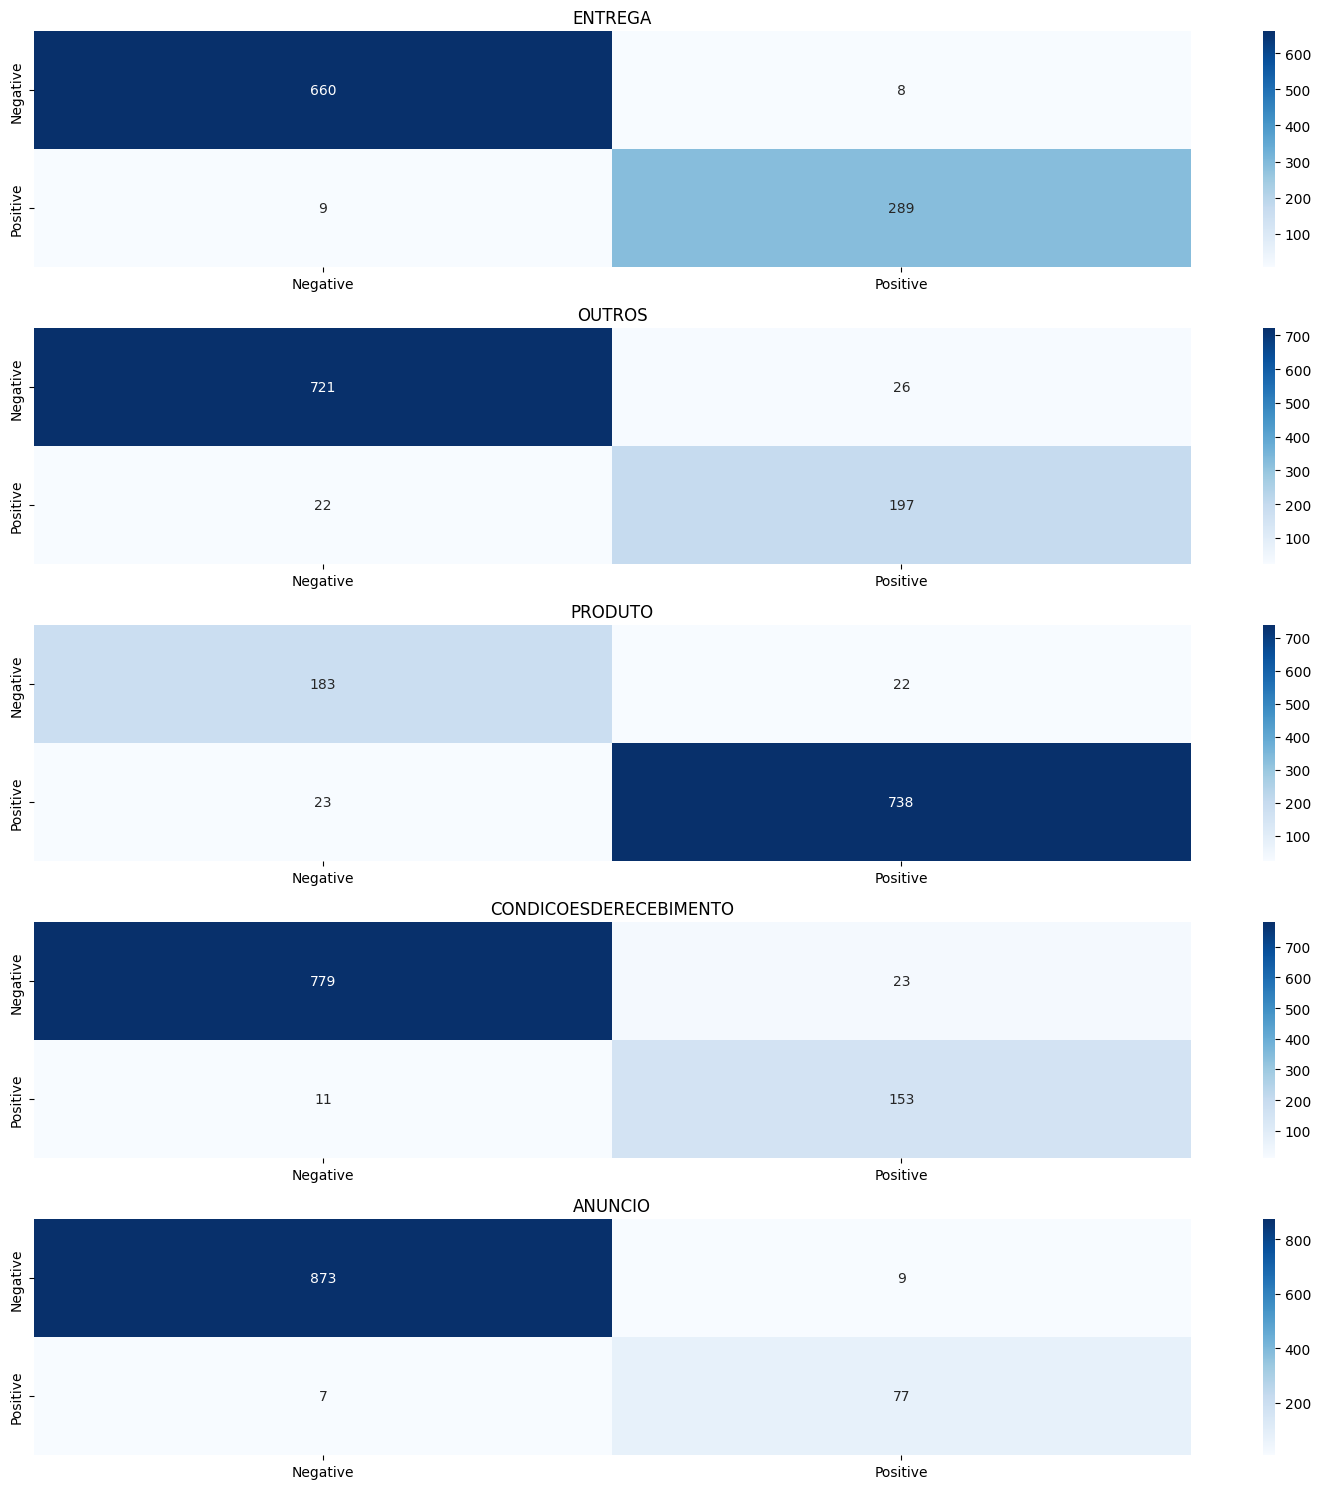

In [ ]:
"""plt.figure(figsize=(15, 3*num_labels))
for i, label_name in enumerate(columns):
    plt.subplot(num_labels, 1, i+1)
    cm = confusion_matrix(y_true[:, i], y_pred_labels[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(label_name)
plt.tight_layout()
plt.show()"""
#for i, label_name in enumerate(columns):
    #plot_label_confusion_matrix(y_true, y_pred_labels, i, label_name)
